In [ ]:
import os
from langchain import vectorstores, document_loaders, embeddings, chat_models, chains, prompts
from langchain.schema import AIMessage, HumanMessage, SystemMessage
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from dotenv import load_dotenv
from langchain.chat_models import ChatOpenAI
import json
from langchain.prompts import PromptTemplate, ChatPromptTemplate
import re
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

load_dotenv('../.env',override=True)



In [ ]:
model_name = 'text-embedding-ada-002'
embeddings = OpenAIEmbeddings(model=model_name)
vectorstore_tad = FAISS.load_local('./faiss_db/tad-db', embeddings)
vectorstore_tad_title = FAISS.load_local('./faiss_db/tad-db-title-key', embeddings)
llm_gpt3 = ChatOpenAI(
    model_name='gpt-3.5-turbo-1106',
    temperature=0.2
)
llm_gpt4 = ChatOpenAI(
    model_name='gpt-4',
    temperature=0.0
)

In [ ]:
file_path = './evaluation/tad-qa-dataset/one-course-dataset.json'
with open(file_path, 'r', encoding="utf-8") as file:
    data = json.load(file)

In [ ]:
data[0]['questions']

In [ ]:
from qa import router

In [ ]:
grades = []
for course_questions in data[:10]:
    for task in course_questions['questions']:
        question = task['question']
        true_answer = task['answer']
        gen_answer = router(query=question)

        qa = PromptTemplate.from_template(
        template=(
            'QA Tester for BME Student Inquiry System\n'
            '----------------------------------------\n'
            'Task: Testing the accuracy of responses related to course information.\n'
            'Objective: Evaluate the correctness of question-answer pairs.\n\n'
            'Given Question: {question}\n'
            'Correct Answer: {true_answer}\n'
            'QA System Response: {gen_answer}\n\n'
            'Evaluation Task: Assess the accuracy of the response.\n'
            'Scoring will be recorded in a JSON file with the following criteria:\n'
            ' - Helpfulness: How useful the response is (Scale: 1-5)\n'
            ' - Correctness: Accuracy of the response (Scale: 1-5)\n'
            ' - Quality: Overall quality of the response (Scale: 1-5)\n\n'
            'Please evaluate and score each response based on these criteria.'
            )
        )
        chain = qa | llm_gpt3


        # Invoke the chain to generate the final response
        result = chain.invoke({'question': question, "true_answer":true_answer, "gen_answer":gen_answer}).content

        grades.append({
            "question": question,
            "true_answer": true_answer,
            "gen_answer": gen_answer,
            "result": result
        })

In [ ]:
grades

In [10]:
len(grades)

21

In [11]:
file_name = "first_ten_graded"
with open(f'evaluation/results/{file_name}.json', 'w', encoding="utf-8") as f:
    json.dump(grades, f, ensure_ascii=False, indent=4)

In [12]:
def extract_first_three_numbers(text):
    matches = re.findall(r"\b[1-6]\b", text)

    # Check if at least three numbers are found
    if matches and len(matches) >= 3:
        return matches[0], matches[1], matches[2]
    else:
        return "Less than three numbers found or pattern not found"

for grade in grades:
    helfulness, correctness, quality = extract_first_three_numbers( grade['result'])
    grade['helfulness'] = helfulness
    grade['correctness'] = correctness
    grade['quality'] = quality

In [13]:
df = pd.DataFrame(grades)
df.to_csv(f'evaluation/results/{file_name}.csv', index=False)


In [22]:
hand_graded = pd.read_csv(f'evaluation/results/{file_name}.csv')
hand_graded_grades = hand_graded[['helfulness','correctness', 'quality']]

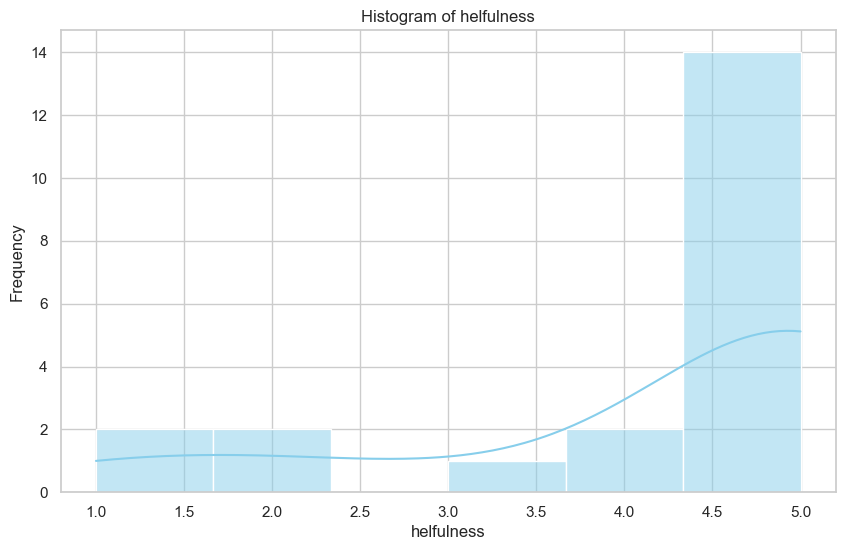

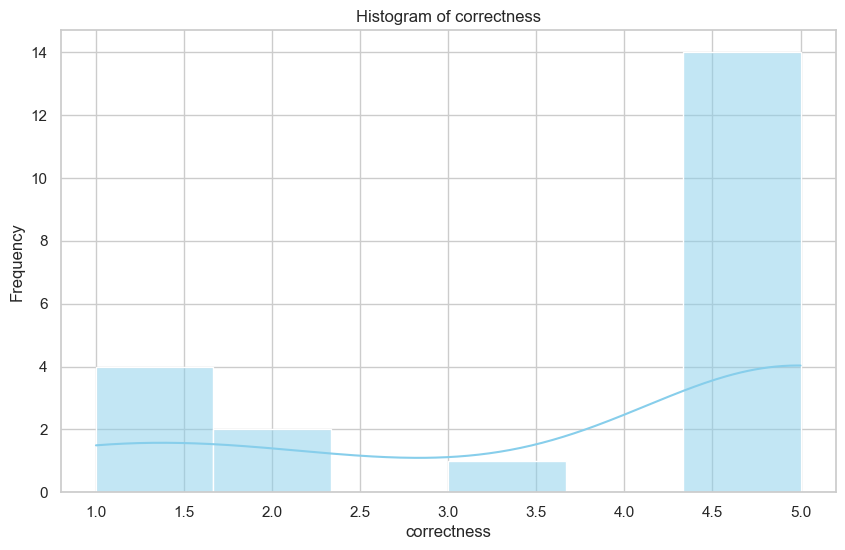

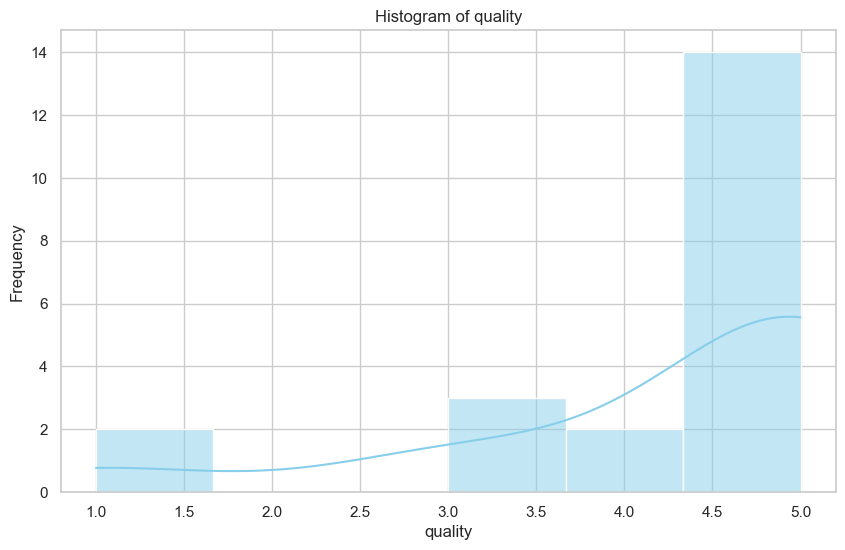

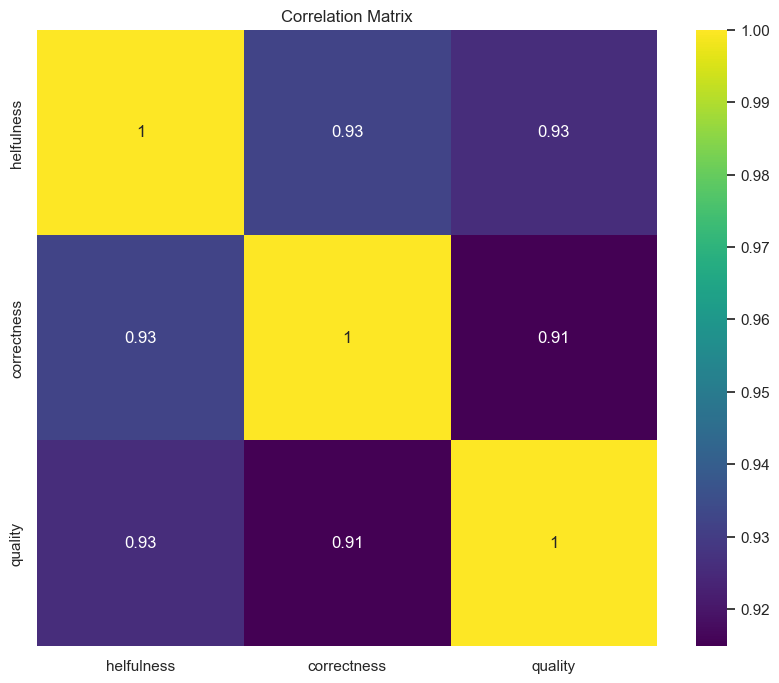

(helfulness     4.142857
 correctness    3.857143
 quality        4.238095
 dtype: float64,
 helfulness     1.424279
 correctness    1.711307
 quality        1.300183
 dtype: float64,
              helfulness  correctness   quality
 helfulness     1.000000     0.931914  0.925728
 correctness    0.931914     1.000000  0.914923
 quality        0.925728     0.914923  1.000000)

In [27]:
mean_values = hand_graded_grades.mean()
std_values = hand_graded_grades.std()
correlation_matrix = hand_graded_grades.corr()

sns.set(style="whitegrid")
for column in hand_graded_grades.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(hand_graded_grades[column], kde=True, color="skyblue")
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="viridis")
plt.title('Correlation Matrix')
plt.show()

mean_values, std_values, correlation_matrix


In [28]:
hand_graded_grades['correct_binary'] = (hand_graded_grades['correctness'] > 3).astype(int)
accuracy = hand_graded_grades['correct_binary'].mean()
accuracy

C:\Users\takat\AppData\Local\Temp\ipykernel_30096\3890453472.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hand_graded_grades['correct_binary'] = (hand_graded_grades['correctness'] > 3).astype(int)


0.6666666666666666